In [1]:
import torch
import torch.nn as nn
import torchvision 
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

from model import ConvAttentionNet
from utils import accuracy, evaluate

In [2]:
# load cifar10 dataset
# The output of torchvision datasets are PILImage images of range [0, 1].
# use random rotation, random crop, random horizontal flip, normalize, and then convert to torch.FloatTensor on training set
# use Normalize on test set

train_tfms = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.RandomErasing(inplace=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

valid_tfms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

trainset = dsets.CIFAR10(root='./data', train=True, download=True, transform=train_tfms)
testset = dsets.CIFAR10(root='./data', train=False, download=True, transform=valid_tfms)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
print(f'Train set size: {len(trainset)}')
print(f'Test set size: {len(testset)}')

Train set size: 50000
Test set size: 10000


In [4]:
# split train dataset into train and validation
train_size = int(len(trainset) * 0.8)
valid_size = len(trainset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(trainset, [train_size, valid_size])

In [5]:
# define dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(dataset=testset, batch_size=64, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


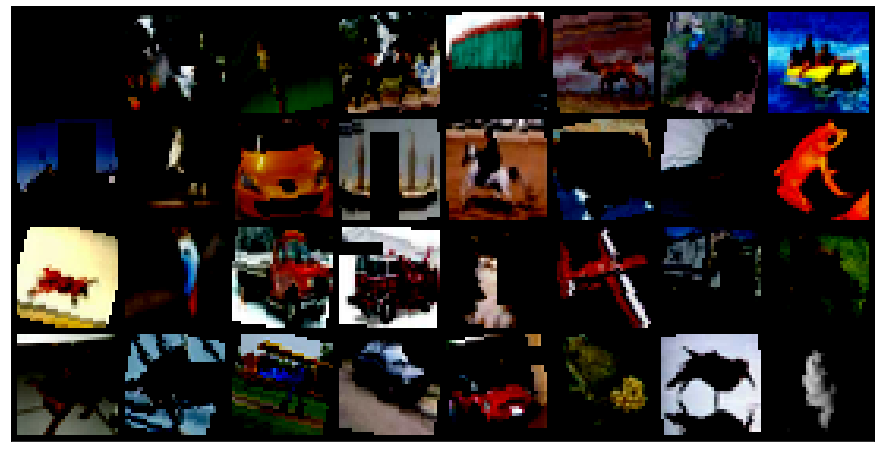

In [6]:
# show some images
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = images
        ax.imshow(torchvision.utils.make_grid(data, nrow=8).permute(1, 2, 0))
        break

show_batch(train_loader)

In [7]:
def train(model, criterion, optimizer, sched, train_loader, valid_loader, device, epochs=10):
    model.train()
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        else:
            print(f'Training loss: {running_loss/len(train_loader)}')
            print('Validation:')
            valid_loss = evaluate(model, criterion, valid_loader, device)
            sched.step(valid_loss/len(valid_loader))
            print(f'Validation loss: {valid_loss/len(valid_loader)}')
    torch.save(model.state_dict(), f'./cifar-10-epoch-{epochs}.pth')

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
model = ConvAttentionNet(3, 10)
model.to(device)

ConvAttentionNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (embedding1): Linear(in_features=128, out_features=1024, bias=True)
  (atten1): Attention(
    (attend): Softmax(dim=-1)
    (to_qkv): Linear(in_features=1024, out_features=1536, bias=False)
    (to_out): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): Dropout(p=0.2, inplace=False)
    )
  )
  (embedding2): Linear(in_features=1024, out_features=128, bias=True)
  (res1): Sequential(
    (0): Sequential(
      (0): 

In [10]:
epochs = 12
weight_decay = 1e-4
lr = 0.008

optimizer = torch.optim.SGD(model.parameters(), lr= lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)
loss_fn = nn.CrossEntropyLoss()

In [11]:
train(model, loss_fn, optimizer, sched, train_loader, valid_loader, device, epochs)

Epoch 1/12
Training loss: 1.5934269109725951
Validation:
Validation loss: 1.4281791524522622
Epoch 2/12
Training loss: 1.5523272586345673
Validation:
Validation loss: 1.1946236369716134
Epoch 3/12
Training loss: 1.1292730672836304
Validation:
Validation loss: 1.0733309779197546
Epoch 4/12
Training loss: 0.9629580702066421
Validation:
Validation loss: 0.9282338361071932
Epoch 5/12
Training loss: 0.8604249377012253
Validation:
Validation loss: 0.8149951977334964
Epoch 6/12
Training loss: 0.6553057194828987
Validation:
Validation loss: 0.7087124128630207
Epoch 7/12
Training loss: 0.6192631148576736
Validation:
Validation loss: 0.6940873832839309
Epoch 8/12
Training loss: 0.5961378490924836
Validation:
Validation loss: 0.694647187829777
Epoch 9/12
Training loss: 0.5827902979850769
Validation:
Validation loss: 0.6603356296089804
Epoch 10/12
Training loss: 0.5544439619064331
Validation:
Validation loss: 0.654398350009493
Epoch 11/12
Training loss: 0.5569905645489692
Validation:
Validation lo

In [13]:
# load saved model and cal test accuracy
model.load_state_dict(torch.load(f'./cifar-10-epoch-{epochs}.pth'))
accuracy(model, test_loader, device)

0.8163